# Experiments for the marker morphologies

## dataset sorting
### load in the data from kaggle

In [1]:
import kagglehub
#to import the data we will use the open datasets library #we place the link copied from Kaggle into the parameter of the download function
#pathB = kagglehub.dataset_download("dextershepherd/tactip-alternative-morphology-b")
#pathnm = kagglehub.dataset_download("dextershepherd/no-marker-tactip-only-glare")
pathA = kagglehub.dataset_download("dextershepherd/tactip-morphology-a-texture",path="/mnt/data0/drs25/data/")
# Download latest version
print("Path to dataset files:", path)

/its/home/drs25/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KaggleApiHTTPError: 400 Client Error: Bad Request for url: https://www.kaggle.com/api/v1/datasets/download/dextershepherd/tactip-morphology-a-texture?dataset_version_number=3&file_name=/mnt/data0/drs25/data/

### convert it all

In [10]:
from convert.convert_data import *
save_path="/mnt/data0/drs25/data/optical-tactile-dataset-for-textures/"
final_data,final_labels=load_files_memory_efficient(pathA+"/")
#final_data=np.load(pathnm+"/X_data_nomarker.npz")['arr_0']
#final_labels=np.load(pathnm+"/y_data_nomarker.npz")['arr_0']
import numpy as np
np.save(save_path+"X_data_morphoholyA",final_data)
np.save(save_path+"y_data_morphoholyA",final_labels)

### Load

In [2]:
import numpy as np
save_path="/mnt/data0/drs25/data/optical-tactile-dataset-for-textures/"

XB=np.load(save_path+"X_data_morphoholyA.npy").astype(np.uint8)#.reshape((41*200,20,355,328))
yB=np.load(save_path+"y_data_morphoholyA.npy").astype(np.uint8)#.reshape((-1,1))


In [15]:
print(XB.shape,yB.shape)

(3000, 20, 110, 120) (3000,)


### Validate 

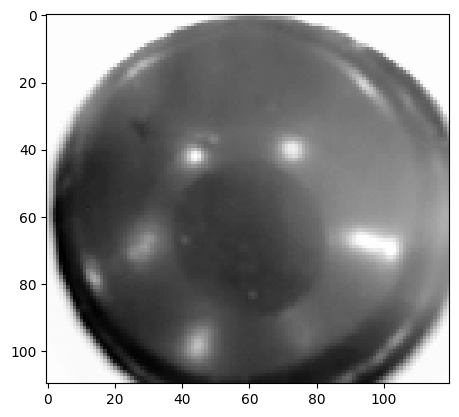

[5 5 5 ... 9 9 9]


In [16]:
import matplotlib.pyplot as plt

plt.imshow(XB[0][0],cmap="gray")
plt.show()
print(yB)

## modelling

In [18]:
import torch
from models import *
from data_loader import * 
from data_format import *
from datapath import *

class data_example(loaded):
    def __init__(self,x,y):
        self.X=x
        self.y=y
data=data_example(XB[:,:7,:,:],yB)
data.applySobel()
print(data.X.shape)
torch.cuda.empty_cache()
train_loader,test_loader=org_data(data,(len(data.X),1,7*data.X.shape[-2],data.X.shape[-1]))
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))

(3000, 7, 110, 120)
LOADED DATASET...
Memory left 23.59 GB
(3000, 7, 110, 120) (3000, 1, 770, 120)
Using 2.07 GB
torch.Size([3000, 1, 770, 120])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32)#.to(device)


Epoch [1/100], Step [48/48], Loss: 129.8846
Epoch [11/100], Step [48/48], Loss: 49.0626
Epoch [21/100], Step [48/48], Loss: 13.4811
Epoch [31/100], Step [48/48], Loss: 5.2277
Epoch [41/100], Step [48/48], Loss: 1.6250
Epoch [51/100], Step [48/48], Loss: 0.4331
Epoch [61/100], Step [48/48], Loss: 0.1948
Epoch [71/100], Step [48/48], Loss: 0.1241
Epoch [81/100], Step [48/48], Loss: 0.0968
Epoch [91/100], Step [48/48], Loss: 0.0719
Finished Training
Accuracy: 99.98333611064822 %
0.9998333611064822
Accuracy: 99.99583350693722 %
0.9999583350693722


In [3]:
import torch
torch.cuda.empty_cache()
from models import *
from data_loader import * 
from data_format import *
from datapath import *
class data_example(loaded):
    def __init__(self,x,y):
        self.X=x
        self.y=y
XB_accuracy=[]

data=data_example(XB[0:3000,:7,:,:],yB)
data.applySobel()
try:
    XB_accuracy=list(np.asarray(np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/XA_accuracy_10.npy")))
    last_point=len(XB_accuracy)
except:
    last_point=0
print("----",last_point)
for i in range(last_point,10):
    try:
        del train_loader,test_loader #housekeeping
    except:
        pass
    torch.cuda.empty_cache()
    train_loader,test_loader=org_data(data,(len(data.X),1,7*data.X.shape[-2],data.X.shape[-1]))
    model,history=run(train_loader,0,4,num_epochs = 100)
    XB_accuracy.append([calc(model,test_loader),calc(model,train_loader)])
    np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/XA_accuracy_10",np.array(XB_accuracy))

XB_accuracy=np.array(XB_accuracy)

np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/X0_accuracy_10",XB_accuracy)

Using device: cuda
Using device: cuda
---- 10


## evaluation

In [7]:
XB=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/XA_accuracy_10.npy")
print(XB)
Av_XB_test=np.average(XB,axis=0)[0]
Av_XB_train=np.average(XB,axis=0)[1]
std_XB_test=np.std(XB[:,0])
print("Average XA test:",Av_XB_test)
print("Average XA train:",Av_XB_train)
print("std XB test:",std_XB_test)


[[0.99983336 0.99995834]
 [0.99316781 0.99995834]
 [0.99150142 0.99995834]
 [0.99316781 0.99995834]
 [0.99650058 0.99995834]
 [0.99316781 0.99995834]
 [0.99483419 0.99995834]
 [0.99650058 0.99995834]
 [0.98983503 0.99995834]
 [0.99983336 0.99995834]]
Average XB test: 0.9948341943009498
Average XB train: 0.9999583350693724
std XB test: 0.003161750701718097


## Map

In [ ]:
data=data_example(XB[0:3000,:7,:,:],yB)
data.applySobel()
images = data.X.reshape((len(data.X),1,7*data.X.shape[-2],data.X.shape[-1]))

input_tensor = torch.tensor(images).clone().detach()
input_tensor.requires_grad = True

output = model(input_tensor)
target_class = output.argmax(dim=1).item() 

model.zero_grad()
output[0, target_class].backward()
saliency = input_tensor.grad.data.abs()

import matplotlib.pyplot as plt

saliency_map = saliency.squeeze().max(dim=0)[0].numpy()  # collapse RGB
plt.imshow(saliency_map, cmap='hot')
plt.axis('off')
plt.title('Saliency Map')
plt.show()